In [1]:
import math
import mlx.core as mx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

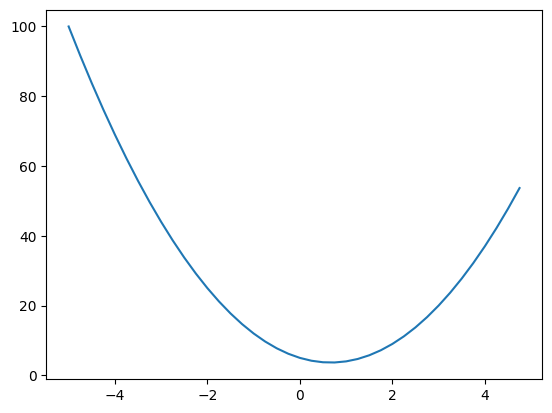

In [4]:
xs = mx.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

**Simple refresher on differentiation**
$$
L = \lim_{h \rightarrow 0}\frac{f(x + h) - f(x)}{h}
$$

In [5]:
h = 0.0001
x = 3.0

In [6]:
f(x), f(x + h)

(20.0, 20.001400030000006)

In [7]:
(f(x + h) - f(x)) / h

14.000300000063248

### **micrograd implementation**

In [8]:
class Value:
  def __init__(self, data, _parents=(), _op=''):
    self.data = data
    self._parents = _parents
    self._op = _op

    # gradient
    self.grad = 0.0 # at init, the value does not affect the output
    self._backward = lambda: None
  
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other: 'Value') -> 'Value':
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __radd__(self, other: 'Value') -> 'Value':
    return self + other
  
  def __mul__(self, other: 'Value') -> 'Value':
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __neg__(self) -> 'Value':
    return -1 * self
  
  def __sub__(self, other: 'Value') -> 'Value':
    return self + (-other)
  
  def __rsub__(self, other: 'Value') -> 'Value':
    return Value(other) - self
  
  def __rmul__(self, other: 'Value') -> 'Value':
    return self * other
  
  def __pow__(self, other: 'Value') -> 'Value':
    assert isinstance(other, (int, float)), "only support int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __truediv__(self, other: 'Value') -> 'Value':
    return self * other**-1
  
  def tanh(self) -> 'Value':
    x = self.data
    _tanh = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(_tanh, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - _tanh ** 2) * out.grad
    out._backward = _backward

    return out
  
  def exp(self) -> 'Value':
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out
  
  def backward(self):
    topo = []
    visited = set()

    def build_topo(v: 'Value'):
      if v not in visited:
        visited.add(v)
        
        for child in v._parents:
          build_topo(child)
        
        topo.append(v)
    
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
# manual backprop
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c

# If we change 'a' by a small amount 'h'
# How would the gradient change?
a = Value(a.data + h)
d_ = a*b + c
print(f"Gradient: {(d_.data - d.data)/h}")

Gradient: -3.000000000010772


**autograd example**

In [10]:
x1 = Value(2.0)
x2 = Value(0.0)

w1 = Value(-3.0)
w2 = Value(1.0)

b = Value(6.8813735870195432)

x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()

### **Neural Network, using micrograd**

In [11]:
import random

class Neuron:
  def __init__(self, n_inputs: int):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
    self.b = Value(random.uniform(-1, 1))
  
  def __call__(self, x: list) -> Value:
    activations = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b)
    out = activations.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

In [12]:
class Layer:
  def __init__(self, n_inputs: int, n_outputs: int):
    self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
  
  def __call__(self, x: list) -> list[Value]:
    outs = [n(x) for n in self.neurons]
    return outs
  
  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]

In [13]:
class MLP:
  def __init__(self, n_inputs: int, n_outputs: int):
    sz = [n_inputs] + n_outputs
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(n_outputs))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [14]:
# single neuron example
x = [2.5, 3.5]
n = Neuron(len(x))
n(x)

Value(data=-0.9996003578010221)

In [15]:
# layer of neurons example
x = [1.5, 4.5]
nn  = Layer(2, 3)
nn(x)

[Value(data=-0.9925180315426618),
 Value(data=-0.9334684394208494),
 Value(data=0.9998730786341865)]

In [16]:
# MLP example: input with 3 neurons, first layers with 4 neurons, second layer with 4 neurons, last output layer with 1 neuron
x = [2.0, 3.0, -1.0]
nn = MLP(3, [4, 4, 1])
nn(x)

[Value(data=0.24818297035972064)]

### **Tune weights of our neural net**

In [72]:
nn = MLP(3, [4, 4, 1])

In [73]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [74]:
# Training loop
lr = 0.05
epochs = 50
for epoch in range(epochs):
  # forward pass
  y_preds = [nn(x) for x in xs]
  loss = sum((y_pred[0] - y_true)**2 for y_true, y_pred in zip(ys, y_preds))

  # backward pass
  for p in nn.parameters(): # zero grad
    p.grad = 0.0
  loss.backward()

  # update
  for p in nn.parameters():
    p.data += -lr * p.grad
  
  print(epoch, loss.data)

0 6.396213210433728
1 4.6713236053103415
2 1.7838028388745268
3 0.9951214940339372
4 0.6244643866397004
5 0.4316410423669388
6 0.31926395466439167
7 0.24840306807651757
8 0.2007423843155306
9 0.1669919570672581
10 0.14208896965193704
11 0.12309433355505289
12 0.10820765800755643
13 0.09627486514636871
14 0.08652715381843712
15 0.07843528216744697
16 0.07162448249002293
17 0.06582279271389418
18 0.06082858473998165
19 0.05648953163226797
20 0.05268861520812526
21 0.04933459347816223
22 0.046355366905371904
23 0.04369327289796304
24 0.04130168994597353
25 0.03914254822288492
26 0.037184478469955776
27 0.03540141743451709
28 0.033771544606773694
29 0.03227646256553751
30 0.030900558653375945
31 0.029630503156717405
32 0.02845485132950758
33 0.027363725187645082
34 0.026348557141398016
35 0.025401881973255196
36 0.024517166914483014
37 0.023688671970382196
38 0.022911334430816083
39 0.022180672846249565
40 0.0214927067685973
41 0.02084388933519709
42 0.020231050374206097
43 0.0196513481750

In [75]:
y_preds

[[Value(data=0.9511549278309712)],
 [Value(data=-0.9459667617553708)],
 [Value(data=-0.9166788866728437)],
 [Value(data=0.9329611039515775)]]